In [49]:
import numpy as np
import pandas as pd
import scipy.linalg as la  # Pure Linear Algebra
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

In [50]:
# 1. Setup Paths
BASE_PATH = "/rds/rds-lxu/ml_datasets/exam_score_predict"
TRAIN_PATH = os.path.join(BASE_PATH, "train.csv")
TEST_PATH = os.path.join(BASE_PATH, "test.csv")

# 2. Load Data (Using pandas to read parquet)
print("Loading data... this might take a minute depending on file size.")
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
# 3. Basic Inspection
print(f"Train Shape: {train_df.shape}")
print(f"Test Shape:  {test_df.shape}")

Loading data... this might take a minute depending on file size.
Train Shape: (630000, 13)
Test Shape:  (270000, 12)


In [51]:
target_col = "exam_score"
numerical_cols = train_df.select_dtypes(include=["int", "float"]).columns.tolist()
categorical_cols = train_df.select_dtypes(include=["object", "category"]).columns.tolist()
print(f"\nNumerical Columns: {numerical_cols}")
print(f"Categorical Columns: {categorical_cols}")

# Verify all columns are categorized
print(len(numerical_cols) + len(categorical_cols) == train_df.shape[1])  

# Remove unecessary columns from lists
numerical_cols.remove(target_col)
numerical_cols.remove("id")

# Feature cleaning
numerical_cols.remove("age") if "age" in numerical_cols else None
categorical_cols.remove("internet_access")
categorical_cols.remove("course")
categorical_cols.remove("gender")
categorical_cols.remove("exam_difficulty")

print(f"\nNumerical Columns after removing target and id: {numerical_cols}")
print(f"Categorical Columns after removing irrelevant features: {categorical_cols}")


Numerical Columns: ['id', 'age', 'study_hours', 'class_attendance', 'sleep_hours', 'exam_score']
Categorical Columns: ['gender', 'course', 'internet_access', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']
True

Numerical Columns after removing target and id: ['study_hours', 'class_attendance', 'sleep_hours']
Categorical Columns after removing irrelevant features: ['sleep_quality', 'study_method', 'facility_rating']


In [52]:
# 1. Prepare X and y
# Using the lists you defined: ['study_hours', 'class_attendance', 'sleep_hours'] etc.
X = train_df[numerical_cols + categorical_cols]
y = train_df[target_col]

# 2. Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
# 3. Lean Preprocessing (No Imputation)
preprocessor = ColumnTransformer(
    transformers=[
        # Scale numerical features so coefficients are comparable
        ('num', StandardScaler(), numerical_cols),
        
        # OHE categorical features. drop='first' prevents multicollinearity
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

In [54]:
# 4. The Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 5. Train
print("Training Linear Regression...")
model.fit(X_train, y_train)

Training Linear Regression...


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [55]:
# 6. Evaluate
y_pred = model.predict(X_val)

rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"\n--- Results ---")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# 7. Extract Coefficients (To understand what drives the score)
# Get feature names from the transformer
feature_names = (numerical_cols + 
                 list(model.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .get_feature_names_out(categorical_cols)))

coefficients = model.named_steps['regressor'].coef_

# Create a clean summary table
coef_df = pd.DataFrame({'Feature': feature_names, 'Weight': coefficients})
coef_df['Abs_Weight'] = coef_df['Weight'].abs()

print("\n--- Top Drivers of Exam Score ---")
print(coef_df.sort_values(by='Abs_Weight', ascending=False).head(5))


--- Results ---
RMSE: 8.8877
R²:   0.7779

--- Top Drivers of Exam Score ---
                      Feature     Weight  Abs_Weight
0                 study_hours  13.398920   13.398920
8     study_method_self-study  -9.102547    9.102547
7  study_method_online videos  -8.288097    8.288097
9         facility_rating_low  -7.273293    7.273293
5    study_method_group study  -7.243201    7.243201


In [56]:
from sklearn.linear_model import Ridge

# 1. Define Pipeline with Ridge
# alpha=1.0 is the default. Higher alpha = more regularization (coefficients shrink more).
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0)) 
])

# 2. Train
print("Training Ridge Regression...")
ridge_pipeline.fit(X_train, y_train)

# 3. Evaluate
y_pred_ridge = ridge_pipeline.predict(X_val)
rmse_ridge = root_mean_squared_error(y_val, y_pred_ridge)
r2_ridge = r2_score(y_val, y_pred_ridge)

print(f"\n--- Ridge Results (alpha=1.0) ---")
print(f"RMSE: {rmse_ridge:.4f}")
print(f"R²:   {r2_ridge:.4f}")

# 4. Check Coefficients
ridge_coefs = ridge_pipeline.named_steps['regressor'].coef_
ridge_df = pd.DataFrame({'Feature': feature_names, 'Weight': ridge_coefs})
ridge_df['Abs_Weight'] = ridge_df['Weight'].abs()

print("\nTop 5 Drivers (Ridge):")
print(ridge_df.sort_values(by='Abs_Weight', ascending=False).head(5))

Training Ridge Regression...

--- Ridge Results (alpha=1.0) ---
RMSE: 8.8877
R²:   0.7779

Top 5 Drivers (Ridge):
                      Feature     Weight  Abs_Weight
0                 study_hours  13.398902   13.398902
8     study_method_self-study  -9.102189    9.102189
7  study_method_online videos  -8.287738    8.287738
9         facility_rating_low  -7.273187    7.273187
5    study_method_group study  -7.242853    7.242853


In [57]:
from sklearn.linear_model import Lasso

# 1. Define Pipeline with Lasso
# We use a smaller alpha (0.1) because Lasso is very sensitive on scaled data.
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.1)) 
])

# 2. Train
print("\nTraining Lasso Regression...")
lasso_pipeline.fit(X_train, y_train)

# 3. Evaluate
y_pred_lasso = lasso_pipeline.predict(X_val)
rmse_lasso = root_mean_squared_error(y_val, y_pred_lasso)
r2_lasso = r2_score(y_val, y_pred_lasso)

print(f"\n--- Lasso Results (alpha=0.1) ---")
print(f"RMSE: {rmse_lasso:.4f}")
print(f"R²:   {r2_lasso:.4f}")

# 4. Check for "Zeroed Out" Features (The Lasso Effect)
lasso_coefs = lasso_pipeline.named_steps['regressor'].coef_
lasso_df = pd.DataFrame({'Feature': feature_names, 'Weight': lasso_coefs})

# Identify features that Lasso decided were useless (Weight == 0)
zero_features = lasso_df[lasso_df['Weight'] == 0]

print(f"\nLasso eliminated {len(zero_features)} features (set weight to 0).")
if not zero_features.empty:
    print("Example eliminated features:", zero_features['Feature'].head(5).tolist())


Training Lasso Regression...

--- Lasso Results (alpha=0.1) ---
RMSE: 8.9589
R²:   0.7743

Lasso eliminated 0 features (set weight to 0).


Training on full dataset (630000 rows)...
Training Complete.
Generating predictions...
Saved 270000 predictions to 'submission_linear_regression.csv'


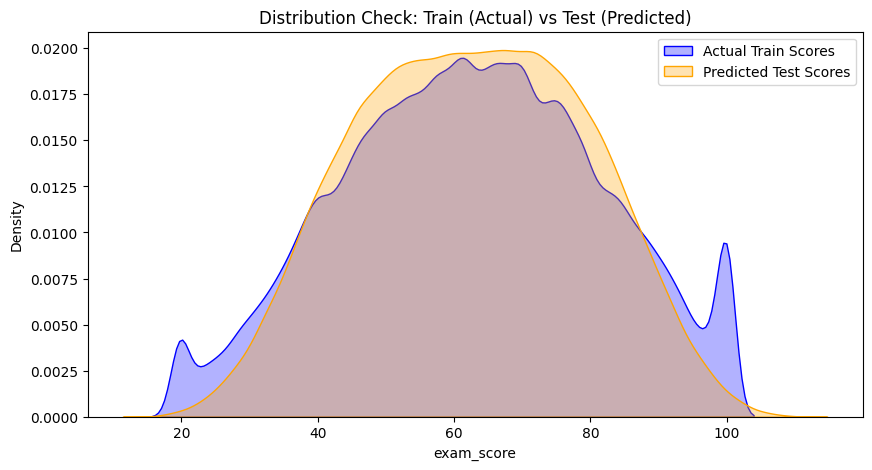

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression

# 1. Prepare Full Training Data
X = train_df[numerical_cols + categorical_cols]
y = train_df[target_col]

# 2. Lean Preprocessing (No Imputation needed)
preprocessor = ColumnTransformer(
    transformers=[
        # Scale numerical features for better coefficient stability
        ('num', StandardScaler(), numerical_cols),
        
        # OHE: drop='first' prevents multicollinearity (Dummy Variable Trap)
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# 3. Define the Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 4. Train on 100% of the Data
print(f"Training on full dataset ({len(X)} rows)...")
model.fit(X, y)
print("Training Complete.")

# 5. Prepare Test Data
# IMPORTANT: Must select exact same columns in same order
X_test = test_df[numerical_cols + categorical_cols]

# 6. Predict
print("Generating predictions...")
final_predictions = model.predict(X_test)

# 7. Sanity Check & Clip (Optional but Recommended)
# If exams are 0-100, linear regression might predict -5 or 105. Clipping fixes this.
# final_predictions = final_predictions.clip(0, 100) 

# 8. Create Submission File
submission = pd.DataFrame({
    'id': test_df['id'],
    'exam_score': final_predictions
})

# Save
submission.to_csv('submission_linear_regression.csv', index=False)
print(f"Saved {len(submission)} predictions to 'submission_linear_regression.csv'")

# --- VISUAL SANITY CHECK ---
# Check if the distribution of predictions matches the distribution of training data
plt.figure(figsize=(10, 5))
sns.kdeplot(y, label='Actual Train Scores', fill=True, color='blue', alpha=0.3)
sns.kdeplot(final_predictions, label='Predicted Test Scores', fill=True, color='orange', alpha=0.3)
plt.title("Distribution Check: Train (Actual) vs Test (Predicted)")
plt.legend()
plt.show()

Training Ridge Regression on full dataset (630000 rows)...
Training Complete.
Generating predictions...
Saved 270000 predictions to 'submission_ridge.csv'


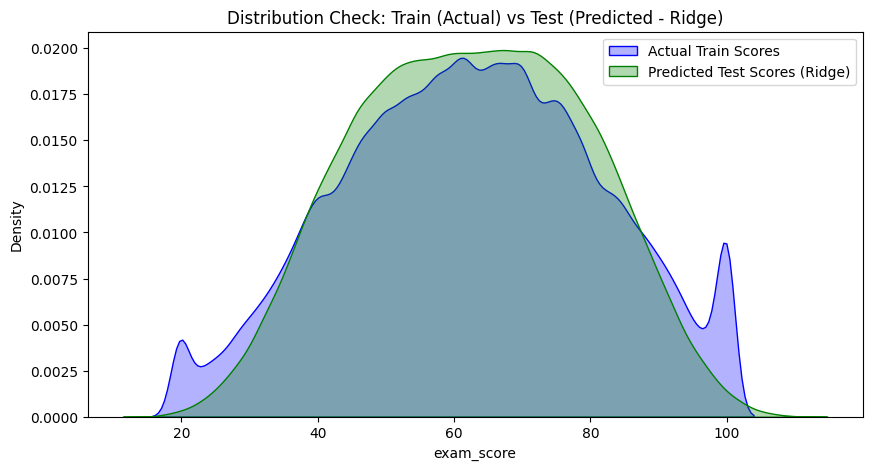

In [59]:
from sklearn.linear_model import Ridge

# 1. Prepare Full Training Data
X = train_df[numerical_cols + categorical_cols]
y = train_df[target_col]

# 2. Lean Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        # drop='first' is still good practice for Ridge, though Ridge handles collinearity better than OLS
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# 3. Define the Ridge Pipeline
# alpha=1.0 is the standard default. 
# If you want more regularization (to reduce overfitting), increase alpha (e.g., 10.0).
model_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

# 4. Train on 100% of the Data
print(f"Training Ridge Regression on full dataset ({len(X)} rows)...")
model_ridge.fit(X, y)
print("Training Complete.")

# 5. Prepare Test Data
X_test = test_df[numerical_cols + categorical_cols]

# 6. Predict
print("Generating predictions...")
final_predictions_ridge = model_ridge.predict(X_test)

# Optional: Clip predictions if exam scores must be 0-100
# final_predictions_ridge = final_predictions_ridge.clip(0, 100)

# 7. Create Submission File
submission_ridge = pd.DataFrame({
    'id': test_df['id'],
    'exam_score': final_predictions_ridge
})

# Save
submission_ridge.to_csv('submission_ridge.csv', index=False)
print(f"Saved {len(submission_ridge)} predictions to 'submission_ridge.csv'")

# --- VISUAL SANITY CHECK ---
plt.figure(figsize=(10, 5))
sns.kdeplot(y, label='Actual Train Scores', fill=True, color='blue', alpha=0.3)
sns.kdeplot(final_predictions_ridge, label='Predicted Test Scores (Ridge)', fill=True, color='green', alpha=0.3)
plt.title("Distribution Check: Train (Actual) vs Test (Predicted - Ridge)")
plt.legend()
plt.show()